
# [ParslFest 2025](https://parsl-project.org/parslfest/parslfest2025.html)

# [Accelerating QMCpy Notebook Tests with Parsl](https://www.figma.com/slides/k7EUosssNluMihkYTLuh1F/Parsl-Testbook-Speedup?node-id=1-37&t=WnKcu2QYO8JXvtpP-0)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/QMCSoftware/QMCSoftware/blob/develop/demos/talk_paper_demos/parsel_fest_2025/parsl_fest_2025.ipynb)

Joshua Herman and Sou-Cheng Choi, QMCPy Developers

Aug 28 -- 29, 2025

Updated: Nov 30, 2025

**Requirements**:

* QMCPy: `pip install qmcpy==2.1`
* LaTeX: `sudo apt update && sudo apt install -y texlive-full`
* testbook : `pip install testbook==0.4.2`
* Parsl: `pip install parsl==2025.7.28`

This notebook can be run interactively or in command line mode. To run in command line mode, use:
```bash
    jupyter nbconvert --to notebook --execute demos/talk_paper_demos/parsel_fest_2025/parsl_fest_2025.ipynb \
  --ExecutePreprocessor.kernel_name=qmcpy --ExecutePreprocessor.timeout=3600 --inplace
```

Our presentation slides for ParslFest are available at [Figma](https://www.figma.com/slides/k7EUosssNluMihkYTLuh1F/Parsl-Testbook-Speedup?node-id=174-95&t=t3jENVMltXWwdLdb-0).

In [2]:
try:
    import parsl as pl
except ModuleNotFoundError:
    !pip install -q parsl

In [ ]:
import sys
import os
import time
import matplotlib.pyplot as plt
import numpy as np

# Ensure the path to the booktests directory is included (robust finder)
def _find_repo_root(start=os.getcwd()):
    cur = start
    while True:
        if os.path.exists(os.path.join(cur, 'pyproject.toml')):
            return cur
        parent = os.path.dirname(cur)
        if parent == cur:
            raise FileNotFoundError('repo root not found')
        cur = parent

sys.path.append(os.path.join(_find_repo_root(), 'test', 'booktests'))

# Configuration flags
# Set force_compute=False to reuse existing outputs; set True to force re-run
force_compute = True
is_debug = True

# Create output directory if it doesn't exist
print(f"{os.getcwd() = }")
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

# Clean local only files if force_compute is set
if force_compute:
    !(cd ../../.. && make clean_local_only_files)
    # remove output directory contents
    !rm -fr output/*.* runinfo/

os.getcwd() = '/workspaces/QMCSoftware/demos/talk_paper_demos/parsel_fest_2025'
rm -fr test/booktests/.ipynb_checkpoints/
chmod +x scripts/find_local_only_folders.sh > /dev/null 2>&1
for f in ; do \
	rm -f "$f"; > /dev/null 2>&1; \
done


## 1. Sequential Execution

In [ ]:
seq_fname = os.path.join(output_dir, "sequential_time.txt")
if (not os.path.exists(seq_fname)) or force_compute:
    start_time = time.time()
    if is_debug:
        !(cd ../../.. && make booktests_no_docker TESTS="tb_quickstart tb_qmcpy_intro")
    else:
        !(cd ../../.. && make booktests_no_docker )
    sequential_time = time.time() - start_time
    
    # save sequential time to a file in output_dir
    with open(seq_fname, "w") as f:
        f.write(f"{sequential_time}\n")

rm -fr demos/.ipynb_checkpoints/*checkpoint.ipynb && \
find demos -name '*.ipynb' | while read nb; do \
	base=$(basename "$nb" .ipynb); \
	test_base=$(echo "$base" | sed 's/[-.]/_/g'); \
	if [ "$base" != "parsl_fest_2025" ] && ! ls test/booktests/tb_"$test_base".py > /dev/null 2>&1; then \
		echo "    Missing test for: $nb -> Expected: test/booktests/tb_$test_base.py"; \
	fi; \
done
Total notebooks:  34
Total test files: 33

Generating missing booktest files...
cd test/booktests/ && python generate_test.py --check-missing
No missing test files found.
rm -fr test/booktests/.ipynb_checkpoints/
chmod +x scripts/find_local_only_folders.sh > /dev/null 2>&1
for f in ; do \
	rm -f "$f"; > /dev/null 2>&1; \
done

Notebook tests
pip install -q -e ".[test]"  && \
set -e && \
cd test/booktests/ && \
if [ -z "tb_quickstart tb_qmcpy_intro" ]; then \
	PYTHONWARNINGS="ignore::UserWarning,ignore::DeprecationWarning,ignore::FutureWarning,ignore::ImportWarning" \
	python -W ignore -m coverage run --appe

In [5]:
# free memory
import gc
gc.collect();

## 2. Parsl

1. Install and Configure Parsl
2. Run the tests in parallel with Parsl

### 2.1 Configure Parsl

In [6]:
from parsl.configs.htex_local import config

config.max_workers = 8  
if not pl.config:
    pl.load(config)
    print("Parsl loaded with memory limits")
else:
    print("Parsl already configured")

Parsl already configured


### 2.2 Create a Parsl Test Runner

In [8]:
import parsl_test_runner
import inspect

# See only functions
print("Functions:")
functions = inspect.getmembers(parsl_test_runner, inspect.isfunction)
for name, func in functions:
    print(f"- {name}")
print("\n" + "="*50)

# Get help on specific function
print("Help for execute_parallel_tests:")
help(parsl_test_runner.execute_parallel_tests)

Functions:
- bash_app
- execute_parallel_tests
- generate_summary_report
- main
- reload_parsl_config

Help for execute_parallel_tests:
Help on function execute_parallel_tests in module parsl_test_runner:

execute_parallel_tests()
    Execute all testbook tests in parallel using Parsl



### 2.3 Run the Notebooks in Parallel with Parsl

In [9]:
par_fname = os.path.join(output_dir, "parallel_time.txt")
if (not os.path.exists(par_fname)) or force_compute:
    start_time2 = time.time()
    if is_debug:
        !(cd ../../.. && make booktests_parallel_no_docker TESTS="tb_quickstart tb_qmcpy_intro")
    else:
        !(cd ../../.. && make booktests_parallel_no_docker)
    parallel_time = time.time() - start_time2

    # save parallel time to file in output_dir
    with open(par_fname, "w") as f:
        f.write(f"{parallel_time}\n")

rm -fr demos/.ipynb_checkpoints/*checkpoint.ipynb && \
find demos -name '*.ipynb' | while read nb; do \
	base=$(basename "$nb" .ipynb); \
	test_base=$(echo "$base" | sed 's/[-.]/_/g'); \
	if [ "$base" != "parsl_fest_2025" ] && ! ls test/booktests/tb_"$test_base".py > /dev/null 2>&1; then \
		echo "    Missing test for: $nb -> Expected: test/booktests/tb_$test_base.py"; \
	fi; \
done
Total notebooks:  34
Total test files: 33

Generating missing booktest files...
cd test/booktests/ && python generate_test.py --check-missing
No missing test files found.
rm -fr test/booktests/.ipynb_checkpoints/
chmod +x scripts/find_local_only_folders.sh > /dev/null 2>&1
for f in ; do \
	rm -f "$f"; > /dev/null 2>&1; \
done

Notebook tests with Parsl
pip install -q -e ".[test]"  && \
cd test/booktests/ && \
rm -fr *.eps *.jpg *.pdf *.png *.part *.txt *.log && rm -fr logs && rm -fr runinfo prob_failure_gp_ci_plots && \
PYTHONWARNINGS="ignore::UserWarning,ignore::DeprecationWarning,ignore::FutureWarning,ign

In [10]:
# read sequential time from file in output_dir
seq_fname = os.path.join(output_dir, "sequential_time.txt")
with open(seq_fname, "r") as f:
    sequential_time = float(f.read().strip())

# read parallel time from file in output_dir
par_fname = os.path.join(output_dir, "parallel_time.txt")
with open(par_fname, "r") as f:
    parallel_time = float(f.read().strip())

In [11]:
speedup = sequential_time / parallel_time
print(f"Sequential time:  {sequential_time:.2f} seconds")
print(f"Parallel time:    {parallel_time:.2f} seconds")
print(f"Speedup by Parsl: {speedup:.2f}")

Sequential time:  22.44 seconds
Parallel time:    16.71 seconds
Speedup by Parsl: 1.34


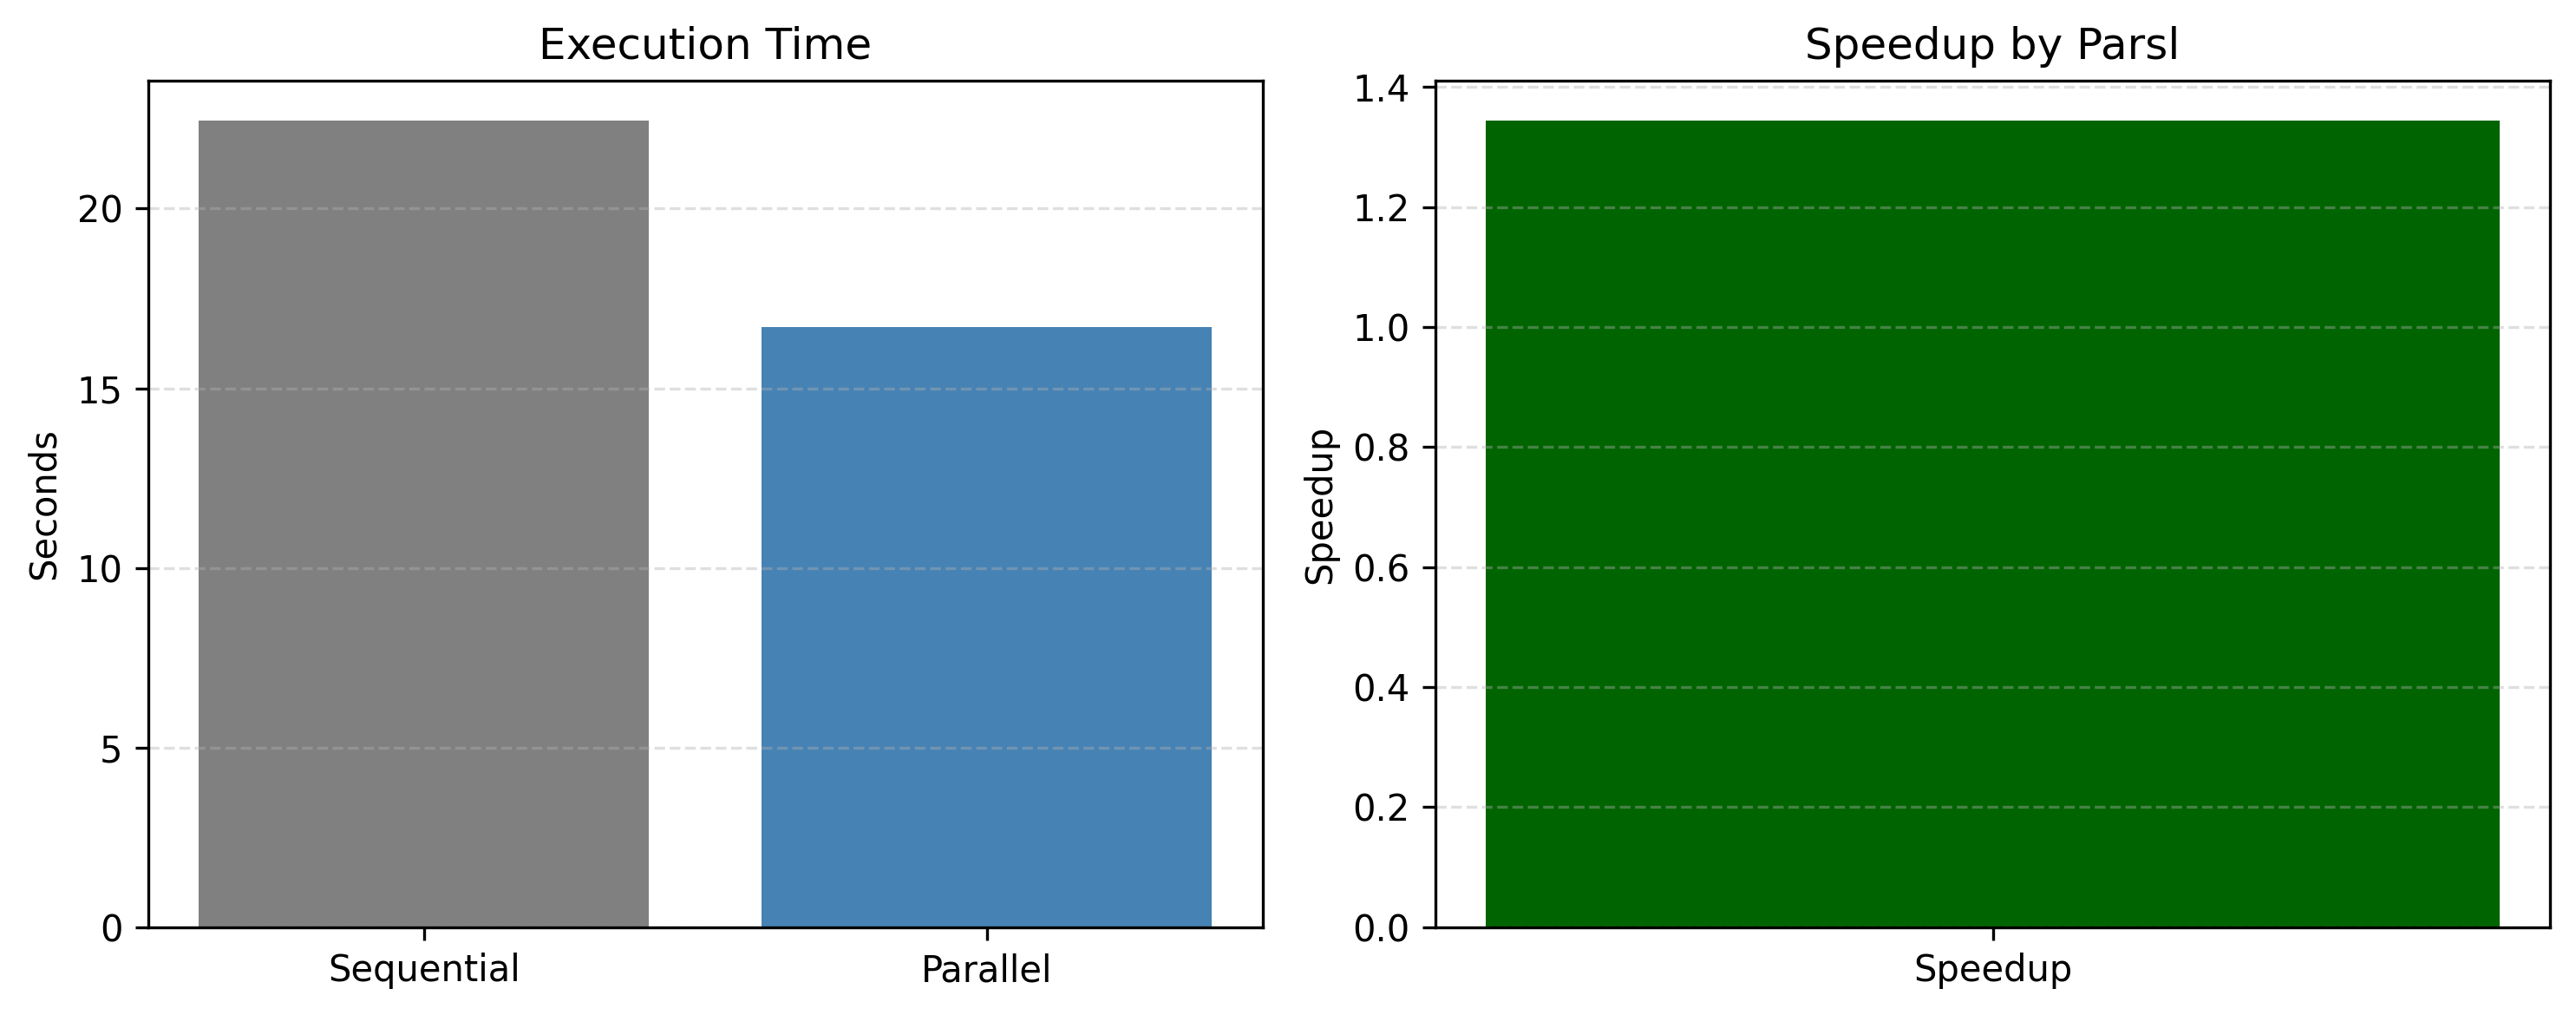

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), dpi=300)

# --- Panel 1: Time ---
axes[0].bar(["Sequential", "Parallel"], [sequential_time, parallel_time], color=["gray", "steelblue"])
axes[0].set_title("Execution Time")
axes[0].set_ylabel("Seconds")
axes[0].grid(axis="y", linestyle="--", alpha=0.4)

# --- Panel 2: Speedup ---
axes[1].bar(["Speedup"], [speedup], color="darkgreen")
axes[1].set_title("Speedup by Parsl")
axes[1].set_ylabel("Speedup")
axes[1].grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
# --- Save as PNG ---
plt.savefig(os.path.join(output_dir, "parsl_speedup.png"), dpi=300, bbox_inches="tight")
plt.show()

### 2.4 Changing the Number of Workers

In [13]:
import gc
import subprocess
import pandas as pd
import parsl_test_runner

# Use CSV for recorded parallel times (one row per worker run)
fname = os.path.join(output_dir, "parallel_times_by_workers.csv")

# If a CSV exists, load recorded workers so we skip them
if os.path.exists(fname):
    _existing = pd.read_csv(fname)
    recorded_workers = set(_existing['workers'].astype(int).tolist()) if 'workers' in _existing.columns else set()
else:
    recorded_workers = set()

# Only run worker sweep if CSV is missing or force_compute is True
if (not os.path.exists(fname)) or force_compute:
    # For quick debugging keep worker_counts small; increase for full runs
    worker_counts = [2] if is_debug else [2, 4]
    parallel_times = []

    for w in worker_counts:
        # Skip if we already have a recorded time for this worker count
        if w in recorded_workers:
            print(f"Skipping workers={w} (already recorded)")
            continue

        # Kill any existing interchange.py processes before reloading Parsl config
        subprocess.run(["pkill", "-f", "interchange.py"])
        try:
            pl = parsl_test_runner.reload_parsl_config(max_workers=w)
        except AssertionError as e:
            if "Already exists!" in str(e):
                print("Parsl interchange process already exists, killing and retrying...")
                subprocess.run(["pkill", "-f", "interchange.py"])
                time.sleep(2)
                gc.collect();
                pl = parsl_test_runner.reload_parsl_config(max_workers=w)
            else:
                raise

        # Small pause and GC before timing
        gc.collect();
        time.sleep(1)

        start = time.time()
        proc = None
        make_arg = 'booktests_parallel_no_docker TESTS="tb_quickstart tb_qmcpy_intro"' if is_debug else 'booktests_parallel_no_docker'
        timeout = 60*1 if is_debug else 60*60  # 1 or 60 mins for debug or full runs 
        try:
            if is_debug:
                proc = subprocess.run(
                    ["bash", "-c", f"cd ../../.. && make {make_arg}"], timeout=timeout
                )
            else:
                proc = subprocess.run(
                    ["bash", "-c", f"cd ../../.. && make {make_arg}"],
                    stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True,
                    timeout=timeout
                )

        except subprocess.TimeoutExpired:
            print("make timed out for workers", w)
            # consider pkill/cleanup here
            subprocess.run(["pkill", "-f", "interchange.py"])
            elapsed = time.time() - start
            # persist the elapsed time for this worker
            row = pd.DataFrame({'workers':[w], 'times':[elapsed]})
            row.to_csv(fname, mode='a', header=not os.path.exists(fname), index=False)
            parallel_times.append(elapsed)
            recorded_workers.add(w)
            continue

        elapsed = time.time() - start
        if proc and proc.returncode != 0:
            print(f"make failed (rc={proc.returncode})")
            # persist stdout/stderr for debugging
            try:
                out_path = os.path.join(output_dir, f"make_w{w}.stdout")
                err_path = sos.path.join(output_dir, f"make_w{w}.stderr")
                with open(out_path, 'w') as _f:
                    _f.write(proc.stdout or '')
                with open(err_path, 'w') as _f:
                    _f.write(proc.stderr or '')
                print(f"Saved stdout/stderr to {out_path} and {err_path}")
            except Exception as _e:
                print(f"Failed saving logs: {_e}")

        # persist result row-wise so subsequent runs can skip completed workers
        row = pd.DataFrame({'workers':[w], 'times':[elapsed]})
        row.to_csv(fname, mode='a', header=not os.path.exists(fname), index=False)

        parallel_times.append(elapsed)
        recorded_workers.add(w)
        print(f"workers={w:2d} -> time={elapsed:.2f}s (rc={proc.returncode})")

Parsl loaded (max_workers=2)
rm -fr demos/.ipynb_checkpoints/*checkpoint.ipynb && \
find demos -name '*.ipynb' | while read nb; do \
	base=$(basename "$nb" .ipynb); \
	test_base=$(echo "$base" | sed 's/[-.]/_/g'); \
	if [ "$base" != "parsl_fest_2025" ] && ! ls test/booktests/tb_"$test_base".py > /dev/null 2>&1; then \
		echo "    Missing test for: $nb -> Expected: test/booktests/tb_$test_base.py"; \
	fi; \
done
Total notebooks:  34
Total test files: 33

Generating missing booktest files...
cd test/booktests/ && python generate_test.py --check-missing
No missing test files found.
rm -fr test/booktests/.ipynb_checkpoints/
chmod +x scripts/find_local_only_folders.sh > /dev/null 2>&1
for f in ; do \
	rm -f "$f"; > /dev/null 2>&1; \
done

Notebook tests with Parsl
pip install -q -e ".[test]"  && \
cd test/booktests/ && \
rm -fr *.eps *.jpg *.pdf *.png *.part *.txt *.log && rm -fr logs && rm -fr runinfo prob_failure_gp_ci_plots && \
PYTHONWARNINGS="ignore::UserWarning,ignore::DeprecationWarn

Saved plot to output/parallel_times_speedup.png


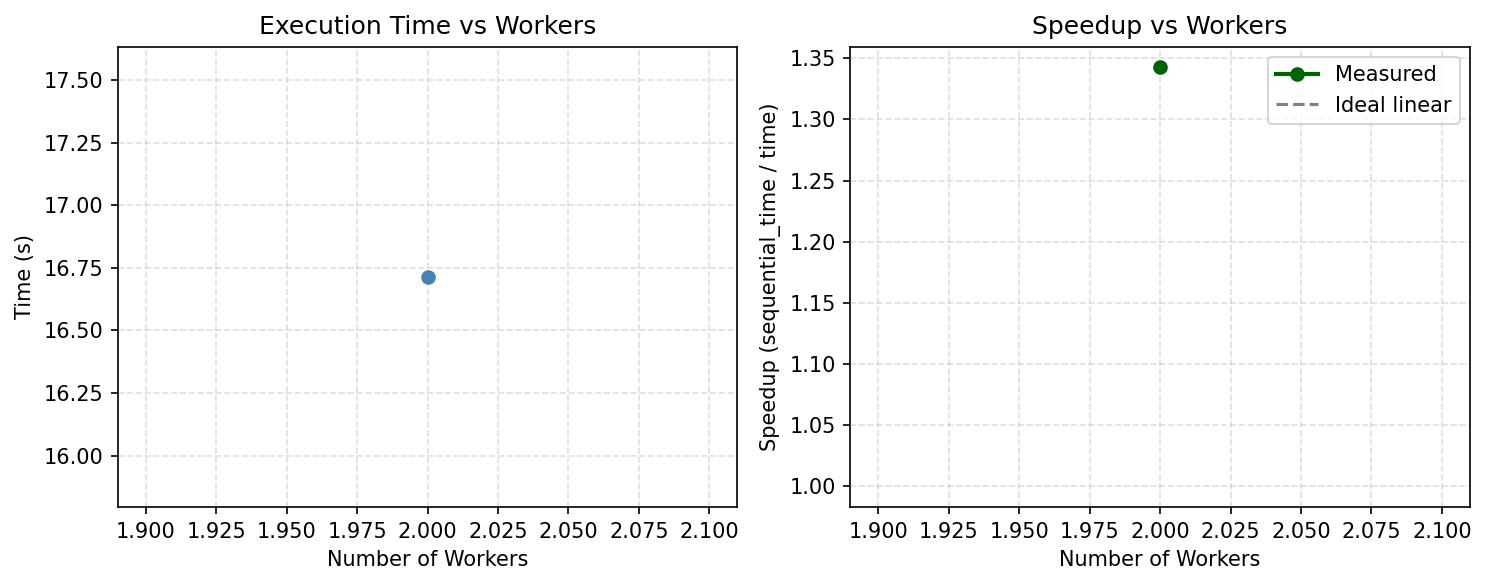

In [14]:
# read sequential time from file in output_dir
seq_fname = os.path.join(output_dir, "sequential_time.txt")
with open(seq_fname, "r") as f:
    sequential_time = float(f.read().strip())

# read CSV of parallel times if it exists
if os.path.exists(fname):
    df = pd.read_csv(fname)
    workers = np.array(df['workers'], dtype=int)
    times = np.array(df['times'], dtype=float)
else:
    try:
        workers = np.array(worker_counts, dtype=int)    # from previous cell
        times = np.array(parallel_times, dtype=float)   # from previous cell
    except NameError:
        raise FileNotFoundError(f"{fname} not found and worker_counts/parallel_times undefined")

# baseline: use sequential_time if available, otherwise fallback to max(times)
try:
    baseline = float(sequential_time)
except NameError:
    baseline = float(times.max())

speedup = baseline / times

fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=150)

# Execution times
# Only plot if both workers and times arrays are non-empty and have the same length
if workers.size > 0 and times.size > 0 and workers.shape == times.shape:
    axes[0].plot(workers, times, marker="o", lw=2, color="steelblue")
else:
    axes[0].text(0.5, 0.5, "No data to plot", ha="center", va="center", fontsize=12)
axes[0].set_xlabel("Number of Workers")
axes[0].set_ylabel("Time (s)")
axes[0].set_title("Execution Time vs Workers")
axes[0].grid(True, linestyle="--", alpha=0.4)

# Speedup
# Only plot if both workers and speedup arrays are non-empty and have the same length
if workers.size > 0 and speedup.size > 0 and workers.shape == speedup.shape:
    axes[1].plot(workers, speedup, marker="o", lw=2, color="darkgreen", label="Measured")
else:
    axes[1].text(0.5, 0.5, "No data to plot", ha="center", va="center", fontsize=12)
ideal = workers / workers[0]
axes[1].plot(workers, ideal, linestyle="--", color="gray", label="Ideal linear")
axes[1].set_xlabel("Number of Workers")
axes[1].set_ylabel("Speedup (sequential_time / time)")
axes[1].set_title("Speedup vs Workers")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
outname = os.path.join(output_dir, "parallel_times_speedup.png")
plt.savefig(outname, dpi=300, bbox_inches="tight")
print(f"Saved plot to {outname}")
plt.show()

In [15]:
!ls -ltr output/
!date

total 252
-rw-rw-rw- 1 codespace codespace     18 Nov 30 18:07 sequential_time.txt
-rw-rw-rw- 1 codespace codespace     18 Nov 30 18:08 parallel_time.txt
-rw-rw-rw- 1 codespace codespace  83682 Nov 30 18:09 parsl_speedup.png
-rw-rw-rw- 1 codespace codespace     34 Nov 30 18:09 parallel_times_by_workers.csv
-rw-rw-rw- 1 codespace codespace 157188 Nov 30 18:10 parallel_times_speedup.png
Sun Nov 30 18:10:18 UTC 2025


### 2.5 OS Info

In [16]:
import platform

if platform.system().lower() == 'linux':
    !uname -a
    !nproc --all
    !awk '/MemTotal/ {printf "%.2f GB\n", $2/1024/1024}' /proc/meminfo

Linux codespaces-6c6933 6.8.0-1030-azure #35~22.04.1-Ubuntu SMP Mon May 26 18:08:30 UTC 2025 x86_64 x86_64 x86_64 GNU/Linux
16
62.80 GB
